### Projeto Módulo 5 - Machine Learning
#### Professor André
#### Tema: Previsão de inadimplência no setor imobiliário
##### Aluno: Daniel Vaz Andrade
##### Turma: 735

In [1]:
# Importando as bibliotecas

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder,OneHotEncoder

In [2]:
# Retirando alertas
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Instanciando os dados de treino em uma variável

df_train = pd.read_csv('application_train.csv')

In [4]:
# Instanciando os dados de teste em uma variável

df_test = pd.read_csv('application_test_student.csv')

In [5]:
# Overview na base de dados de treino

df_train.head(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,456162,0,Cash loans,F,N,N,0,112500.0,700830.0,22738.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,134978,0,Cash loans,F,N,N,0,90000.0,375322.5,14422.5,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,3.0
2,318952,0,Cash loans,M,Y,N,0,180000.0,544491.0,16047.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,3.0


In [6]:
# Overview na base de dados de test

df_test.head(3)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,149741,Cash loans,F,N,N,0,117000.0,417024.0,20191.5,360000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
1,363290,Cash loans,M,N,Y,0,450000.0,640080.0,31261.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
2,436006,Revolving loans,M,Y,Y,0,450000.0,900000.0,45000.0,900000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,0.0


In [7]:
# Análise da coluna 'Target' nos dados de treino

df_train['TARGET'].value_counts()

0    226038
1     19970
Name: TARGET, dtype: int64

#### Observação: esse resultado mostra um desequilíbrio muito grande no volume de dados. Caso isso não seja tratado, haverá uma tendência do modelo tratar os inadimplentes (1) como bons pagadores (0).

*PODEMOS POR EXEMPLO USAR O XGBOOST PARA TRATAR ESSE PROBLEMA*

In [8]:
# Tipos de dados nas colunas

df_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [9]:
# Informações únicas dentro de cada coluna categórica. Veja:

df_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

#### Verificando os tipos de dados por coluna verificamos que 16/122 possuem dados categóricos que antes de serem utilizados terão que ser codificados. (Ex: N será substituído por 0 e Y por 1)

Nesse caso especificamente, vamos seguir o princípio abaixo:

Colunas com dois ou menos objetos usaremos o *Label_encoder* e nas demais o *One-hot encoder*

In [10]:
# Checando os nulos

nulos_df_train = df_train.isnull().sum()

In [11]:
# Percentual nulos

percentual_nulos = 100 * df_train.isnull().sum() / len(df_train)

In [12]:
# Visualizando os dados

tabela_nulos = pd.concat([nulos_df_train, percentual_nulos], axis=1)
tabela_nulos.head(3)

,0,1
SK_ID_CURR,0,0.0
TARGET,0,0.0
NAME_CONTRACT_TYPE,0,0.0


In [13]:
# Renomeando as colunas

tabela_nulos_renomeada = tabela_nulos.rename(columns = {0 : 'Valores nulos', 1 : '% do Total'})

# Ordenando de forma decrescente

tabela_nulos_ordenada = tabela_nulos_renomeada[tabela_nulos_renomeada.iloc[:,1] != 0].sort_values(
    '% do Total', ascending=False).round(1)
tabela_nulos_ordenada.head(20)

,Valores nulos,% do Total
COMMONAREA_MEDI,171978,69.9
COMMONAREA_AVG,171978,69.9
COMMONAREA_MODE,171978,69.9
NONLIVINGAPARTMENTS_MEDI,170914,69.5
NONLIVINGAPARTMENTS_MODE,170914,69.5
NONLIVINGAPARTMENTS_AVG,170914,69.5
FONDKAPREMONT_MODE,168392,68.4
LIVINGAPARTMENTS_MODE,168278,68.4
LIVINGAPARTMENTS_MEDI,168278,68.4
LIVINGAPARTMENTS_AVG,168278,68.4


In [14]:
# Perceba que temos variáveis categóricas que necessitam de um 'encoding'. Seguem dois exemplos:

display(df_train['OCCUPATION_TYPE'].head(5))
display(df_train['FLAG_OWN_CAR'].head(5))

0               Core staff
1    High skill tech staff
2                 Managers
3                      NaN
4                 Laborers
Name: OCCUPATION_TYPE, dtype: object

0    N
1    N
2    Y
3    N
4    N
Name: FLAG_OWN_CAR, dtype: object

In [15]:
# Utilizando o LabelEncoder
label_encoder = LabelEncoder()
label_encoder_qtd = 0

# Usar um looping simples para iterar as colunas
for col in df_train:
    if df_train[col].dtype == 'object':
        # Condicional para até dois valores unicos
        if len(list(df_train[col].unique())) <= 2:
            # Trainando o df_treino
            label_encoder.fit(df_train[col])
            # Transform no treino
            df_train[col] = label_encoder.transform(df_train[col])
                        
            label_encoder_qtd += 1
            
print('%d colunas foram transformadas com o LabelEncoder.' % label_encoder_qtd)

3 colunas foram transformadas com o LabelEncoder.


In [16]:
# Trabalhando com one-hot encoding

df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

print('df_treino: ', df_train.shape)
print('df_test: ', df_test.shape)

df_treino:  (246008, 243)
df_test:  (61503, 244)


#### Importante
Para seguirmos é importante que os dataframes de treino e teste tenham as mesmas colunas, com exceção feita a coluna 'TARGET'. Assim, após o ajuste é esperado que o dataframe de treino tenha uma coluna a mais que o de teste.

In [17]:
flag_treino = df_train['TARGET']

# Igualando as colunas de treino e teste
df_train, df_test = df_train.align(df_test, join = 'inner', axis = 1)

# Add the target back in
df_train['TARGET'] = flag_treino

print('Shape df_treino: ', df_train.shape)
print('Shape df_test: ', df_test.shape)

Shape df_treino:  (246008, 239)
Shape df_test:  (61503, 238)


### Checagem dos nulos (após as modificações)

In [18]:
# Verificando novamente os dados nulos em treino

display(df_train.isnull().sum().sort_values(ascending=False))

COMMONAREA_MEDI                          171978
COMMONAREA_MODE                          171978
COMMONAREA_AVG                           171978
NONLIVINGAPARTMENTS_AVG                  170914
NONLIVINGAPARTMENTS_MEDI                 170914
                                          ...  
NAME_EDUCATION_TYPE_Academic degree           0
NAME_EDUCATION_TYPE_Higher education          0
NAME_EDUCATION_TYPE_Incomplete higher         0
NAME_EDUCATION_TYPE_Lower secondary           0
TARGET                                        0
Length: 239, dtype: int64

In [19]:
# Verificando novamente os dados nulos em test

display(df_test.isnull().sum().sort_values(ascending=False))

COMMONAREA_MODE                          42887
COMMONAREA_AVG                           42887
COMMONAREA_MEDI                          42887
NONLIVINGAPARTMENTS_MODE                 42600
NONLIVINGAPARTMENTS_AVG                  42600
                                         ...  
NAME_INCOME_TYPE_Working                     0
NAME_EDUCATION_TYPE_Academic degree          0
NAME_EDUCATION_TYPE_Higher education         0
NAME_EDUCATION_TYPE_Incomplete higher        0
EMERGENCYSTATE_MODE_Yes                      0
Length: 238, dtype: int64

#### Nesse ponto, vale conferir a correlação das variáveis com o 'TARGET'

In [20]:
correlacoes = df_train.corr()['TARGET'].sort_values(ascending=False)

print('Correlacoes Positivas:\n', correlacoes.head(15))
print('\nCorrelacoes Negativas:\n', correlacoes.tail(15))

Correlacoes Positivas:
 TARGET                                               1.000000
DAYS_BIRTH                                           0.079414
REGION_RATING_CLIENT_W_CITY                          0.061518
REGION_RATING_CLIENT                                 0.059170
NAME_INCOME_TYPE_Working                             0.056355
CODE_GENDER_M                                        0.055221
DAYS_LAST_PHONE_CHANGE                               0.054471
DAYS_ID_PUBLISH                                      0.051572
REG_CITY_NOT_WORK_CITY                               0.050255
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049527
FLAG_EMP_PHONE                                       0.045894
REG_CITY_NOT_LIVE_CITY                               0.045404
FLAG_DOCUMENT_3                                      0.044072
OCCUPATION_TYPE_Laborers                             0.043102
DAYS_REGISTRATION                                    0.041581
Name: TARGET, dtype: float64

Correlacoes Nega

In [21]:
#Verificando a coluna com melhor correlação

df_train['DAYS_BIRTH'].describe()

count    246008.000000
mean     -16042.794393
std        4365.973763
min      -25229.000000
25%      -19691.000000
50%      -15763.000000
75%      -12418.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

In [22]:
# Impacto da coluna da idade na capacidade de pagamento

df_train['DAYS_BIRTH'] = abs(df_train['DAYS_BIRTH'])
df_train['DAYS_BIRTH'].corr(df_train['TARGET'])

-0.07941381167399117

**A medida que os clientes envelhecem, eles tendem a pagar seus empréstimos com mais frequência. Portanto, vamos dar avaliar a distribuição das idades relacionadas**

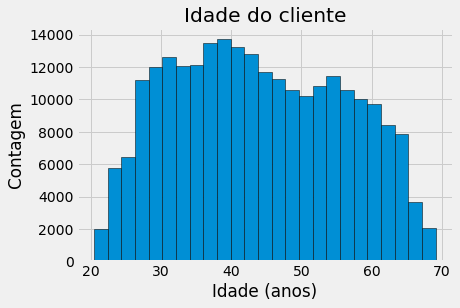

In [23]:
# Na linha 5 foi dividido por 365 para transformar em anos

plt.style.use('fivethirtyeight')

plt.hist(df_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25) 
plt.title('Idade do cliente'); plt.xlabel('Idade (anos)'); plt.ylabel('Contagem');

#### Uma boa ferramenta que cai como uma luva agora seria o KDE(kernel density estimation). Com ela podemos correlacionar a idade com o Target. 

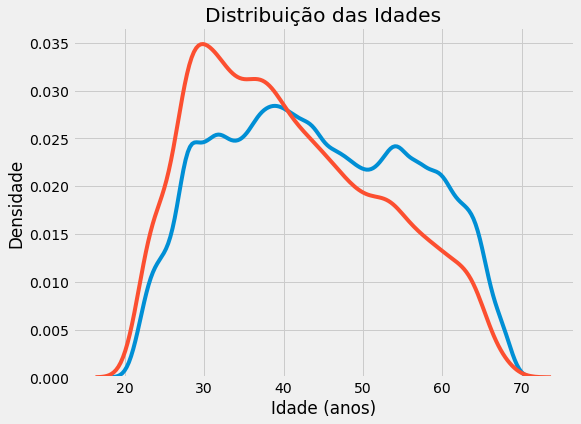

In [24]:
plt.figure(figsize = (8, 6))

# Empréstimos que foram pagos no prazo
sns.kdeplot(df_train.loc[df_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# Empréstimos que não foram pagos no prazo
sns.kdeplot(df_train.loc[df_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Gráfico final
plt.xlabel('Idade (anos)'); plt.ylabel('Densidade'); plt.title('Distribuição das Idades');

In [25]:
# Criando um dataframe com as maiores correlações

df_corr = df_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
df_maiores_corr = df_corr.corr()
df_maiores_corr

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.158619,-0.160978,-0.179246,-0.079414
EXT_SOURCE_1,-0.158619,1.000000,0.213543,0.185861,0.601492
EXT_SOURCE_2,-0.160978,0.213543,1.000000,0.106642,0.091906
EXT_SOURCE_3,-0.179246,0.185861,0.106642,1.000000,0.204027
DAYS_BIRTH,-0.079414,0.601492,0.091906,0.204027,1.000000


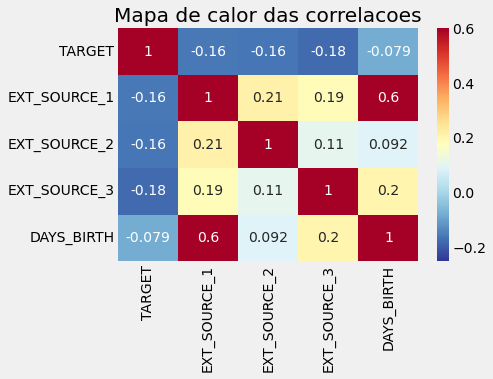

In [26]:
plt.figure(figsize = (6, 4))

# Mapa de calor
sns.heatmap(df_maiores_corr, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Mapa de calor das correlacoes');

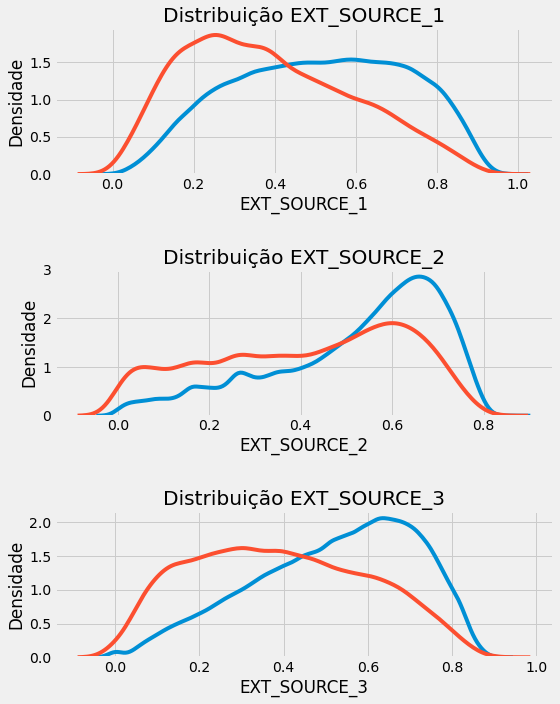

In [27]:
plt.figure(figsize = (8, 10))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # Criar um subplot para cada fonte
    plt.subplot(3, 1, i + 1)
    
    # Empréstimos pagos
    sns.kdeplot(df_train.loc[df_train['TARGET'] == 0, source], label = 'target == 0')
    
    # Empréstimos não pagos
    sns.kdeplot(df_train.loc[df_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribuição %s' % source)
    plt.xlabel('%s' % source); plt.ylabel('Densidade');
    
plt.tight_layout(h_pad = 2.5)

### Começando os trabalhos de Machine Learning

O Polynomial Features nos permitirá alimentar interações entre recursos de entrada para o nosso modelo. Essa funcionalidade nos ajuda a explorar relações não lineares como capacidade de pagamento com idade.

In [28]:
# Criar um novo dataframe com polinomial features
poli_features = df_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poli_features_test = df_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# SimpleImputer para correcao de dados
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')

poli_target = poli_features['TARGET']

poli_features = poli_features.drop(columns = ['TARGET'])

# Need to impute missing values
poli_features = imputer.fit_transform(poli_features)
poli_features_test = imputer.transform(poli_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poli_transformer = PolynomialFeatures(degree = 3)

In [29]:
# Treinar o df com polinomialfeatures
poli_transformer.fit(poli_features)

# Transform the features
poli_features = poli_transformer.transform(poli_features)
poli_features_test = poli_transformer.transform(poli_features_test)
print('Shape Polinomial_Features: ', poli_features.shape)

Shape Polinomial_Features:  (246008, 35)


In [30]:
# Verificando os nomes

poli_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

#### Visualizando outras variáveis

In [31]:
df_train_domain = df_train.copy()

df_test_domain = df_test.copy()

df_train_domain['CREDIT_INCOME_PERCENT'] = df_train_domain['AMT_CREDIT'] / df_train_domain['AMT_INCOME_TOTAL']

df_train_domain['ANNUITY_INCOME_PERCENT'] = df_train_domain['AMT_ANNUITY'] / df_train_domain['AMT_INCOME_TOTAL']

df_train_domain['CREDIT_TERM'] = df_train_domain['AMT_ANNUITY'] / df_train_domain['AMT_CREDIT']

df_train_domain['DAYS_EMPLOYED_PERCENT'] = df_train_domain['DAYS_EMPLOYED'] / df_train_domain['DAYS_BIRTH']

df_test_domain['CREDIT_INCOME_PERCENT'] = df_test_domain['AMT_CREDIT'] / df_test_domain['AMT_INCOME_TOTAL']

df_test_domain['ANNUITY_INCOME_PERCENT'] = df_test_domain['AMT_ANNUITY'] / df_test_domain['AMT_INCOME_TOTAL']

df_test_domain['CREDIT_TERM'] = df_test_domain['AMT_ANNUITY'] / df_test_domain['AMT_CREDIT']

df_test_domain['DAYS_EMPLOYED_PERCENT'] = df_test_domain['DAYS_EMPLOYED'] / df_test_domain['DAYS_BIRTH']

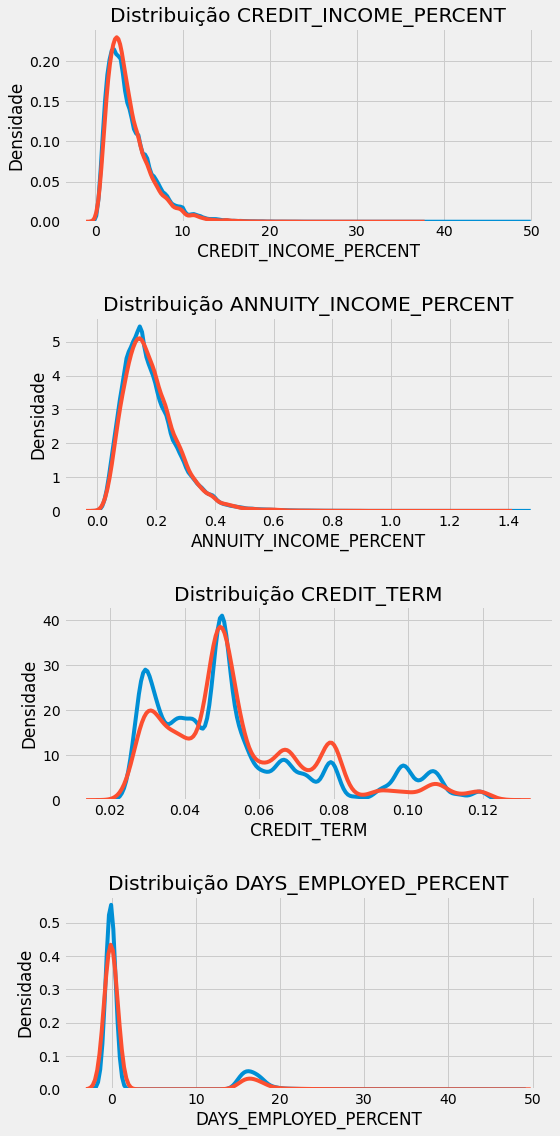

In [32]:
plt.figure(figsize = (8, 16))
# Iterando as novas features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    # Subplot por cada fonte
    plt.subplot(4, 1, i + 1)
    # Empréstimo pago
    sns.kdeplot(df_train_domain.loc[df_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # Empréstimo não pago
    sns.kdeplot(df_train_domain.loc[df_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    # Gráfico Final
    plt.title('Distribuição %s' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Densidade');
    
plt.tight_layout(h_pad = 2.5)

#### Vamos usar uma Regresão Linear na baseline

In [36]:
from sklearn.preprocessing import MinMaxScaler

# Drop o 'Target' dos dados de treino
if 'TARGET' in df_train:
    train = df_train.drop(columns = ['TARGET'])
else:
    train = df_train.copy()
    
# Nomes das Features
features = list(train.columns)

# Cópia dos dados de teste
test = df_test.copy()

# Aplicando MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

# Fitando os dados de treino
imputer.fit(train)

# Transformando os dados de treino e teste
train = imputer.transform(train)
test = imputer.transform(df_test)

# Repetir com dados 'scaler'
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Shape dados treino: ', train.shape)
print('Shape dados teste: ', test.shape)

Shape dados treino:  (246008, 238)
Shape dados teste:  (61503, 238)


In [38]:
# Aplicando a Regressão Linear

from sklearn.linear_model import LogisticRegression

# Armazenando a regressão em uma variável
log_reg = LogisticRegression(C = 0.0001)

# Treinando os dados de treino
log_reg.fit(train, flag_treino)

LogisticRegression(C=0.0001)

In [39]:
# Predições
# Garantindo a seleção correta das colunas
log_reg_pred = log_reg.predict_proba(test)[:, 1]

In [42]:
# Dataframe final
df_final = df_test[['SK_ID_CURR']]
df_final['TARGET'] = log_reg_pred

df_final.head()

,SK_ID_CURR,TARGET
0,149741,0.108556
1,363290,0.071518
2,436006,0.084218
3,377703,0.119553
4,188624,0.110971


In [43]:
# Salvando o arquivo csv
df_final.to_csv('predicao_regressao_logistica.csv', index = False)

### Aplicando Random Forest

In [44]:
from sklearn.ensemble import RandomForestClassifier

# Iterando o Random Forest
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [45]:
# Train on the training data
random_forest.fit(train, flag_treino)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
predictions = random_forest.predict_proba(test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.4s finished


In [47]:
# Criando dataframe de entrega
final_randomforest = df_test[['SK_ID_CURR']]
final_randomforest['TARGET'] = predictions

# Save the submission dataframe
final_randomforest.to_csv('predicao_random_forest.csv', index = False)

In [51]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc

def model(features, test_features, encoding = 'ohe', n_folds = 5):

    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [52]:
submission, fi, metrics = model(df_train, df_test)
print('Baseline metrics')
print(metrics)

Training Data Shape:  (246008, 237)
Testing Data Shape:  (61503, 237)
[200]	train's auc: 0.804789	train's binary_logloss: 0.542674	valid's auc: 0.759614	valid's binary_logloss: 0.55908
[200]	train's auc: 0.806124	train's binary_logloss: 0.541718	valid's auc: 0.758044	valid's binary_logloss: 0.560483
[200]	train's auc: 0.805364	train's binary_logloss: 0.542194	valid's auc: 0.754371	valid's binary_logloss: 0.561601
[200]	train's auc: 0.805293	train's binary_logloss: 0.541908	valid's auc: 0.754685	valid's binary_logloss: 0.561266
[200]	train's auc: 0.805658	train's binary_logloss: 0.541883	valid's auc: 0.757227	valid's binary_logloss: 0.558971
Baseline metrics
      fold     train     valid
0        0  0.799497  0.759917
1        1  0.801734  0.758261
2        2  0.817475  0.754876
3        3  0.815117  0.755374
4        4  0.801325  0.757423
5  overall  0.807030  0.757139


In [56]:
# Salvando o dataframe de envio

submission.to_csv('dataframe_final_rocauc.csv', index = False)

#### Referências técnicas

https://machinelearningknowledge.ai/categorical-data-encoding-with-sklearn-labelencoder-and-onehotencoder/#:~:text=%20Example%20of%20LabelEncoder%20in%20Sklearn%20%201,has%20the%20module%20LabelEncoder%20%28%29%20that...%20More%20

https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer

https://scikit-learn.org/stable/modules/impute.html